In [12]:
from platform import python_version
print(python_version() )
import rebound
print(rebound.__version__)

3.10.9
3.17.3


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import dask.dataframe as dd
import rebound
%matplotlib inline
#change it to my dictionary
datafolder = '/home/yba/spock/data/'
Nout = 1729


/tmp/ipykernel_490787/1021776980.py:4: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  df = pd.read_csv('/home/yba/spock/training_data/resonant/runstrings.csv', header=None, index_col=0, squeeze=True)


(<Figure size 500x500 with 1 Axes>, <AxesSubplot: xlabel='x', ylabel='y'>)

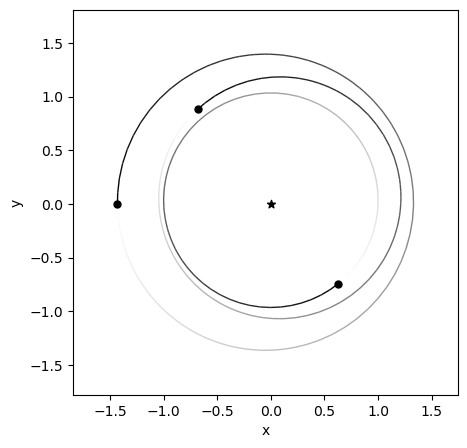

In [13]:
## read initial condition from CSV

#testing
df = pd.read_csv('/home/yba/spock/training_data/resonant/runstrings.csv', header=None, index_col=0, squeeze=True)

# convert the dataframe into a dictionary
my_dict = df.to_dict()

# the binary file name you want to search for
binary_file_name = "0000010.bin"

# search for the binary file name in the dictionary
for key, value in my_dict.items():
    if value == binary_file_name:
        i = int(key)


all_data = np.loadtxt('initial_condition_resonant.csv', delimiter=',',dtype=np.float64)
# get corresponding row
data = all_data[i]
# create a new simulation
sim = rebound.Simulation()
sim.G=4*np.pi**2
sim.add(m=data[0], x=data[1], y=data[2], z=data[3], vx=data[4], vy=data[5], vz=data[6])
sim.add(m=data[7], x=data[8], y=data[9], z=data[10], vx=data[11], vy=data[12], vz=data[13])
sim.add(m=data[14], x=data[15], y=data[16], z=data[17], vx=data[18], vy=data[19], vz=data[20])
sim.add(m=data[21], x=data[22], y=data[23], z=data[24], vx=data[25], vy=data[26], vz=data[27])

rebound.OrbitPlot(sim)

In [14]:
from collections import OrderedDict
import sys
sys.path.append('../spock')
sys.path.append('../../spock')
from simsetup import init_sim_parameters
from feature_functions import features

kwargs = OrderedDict()
kwargs['Norbits'] = 1e4
kwargs['Nout'] = 80 
kwargs['trio'] = [[1,2,3]]
args = list(kwargs.values())
init_sim_parameters(sim)


In [15]:
#features function

import rebound
import numpy as np
from collections import OrderedDict

######################### Taken from celmech github.com/shadden/celmech
def farey_sequence(n):
    """Return the nth Farey sequence as order pairs of the form (N,D) where `N' is the numerator and `D' is the denominator."""
    a, b, c, d = 0, 1, 1, n
    sequence=[(a,b)]
    while (c <= n):
        k = int((n + b) / d)
        a, b, c, d = c, d, (k*c-a), (k*d-b)
        sequence.append( (a,b) )
    return sequence
def resonant_period_ratios(min_per_ratio,max_per_ratio,order):
    """Return the period ratios of all resonances up to order 'order' between 'min_per_ratio' and 'max_per_ratio' """
    if min_per_ratio < 0.:
        raise AttributeError("min_per_ratio of {0} passed to resonant_period_ratios can't be < 0".format(min_per_ratio))
    if max_per_ratio >= 1.:
        raise AttributeError("max_per_ratio of {0} passed to resonant_period_ratios can't be >= 1".format(max_per_ratio))
    minJ = int(np.floor(1. /(1. - min_per_ratio)))
    maxJ = int(np.ceil(1. /(1. - max_per_ratio)))
    res_ratios=[(minJ-1,minJ)]
    for j in range(minJ,maxJ):
        res_ratios = res_ratios + [ ( x[1] * j - x[1] + x[0] , x[1] * j + x[0]) for x in farey_sequence(order)[1:] ]
    res_ratios = np.array(res_ratios)
    msk = np.array( list(map( lambda x: min_per_ratio < x[0]/float(x[1]) < max_per_ratio , res_ratios )) )
    return res_ratios[msk]
##########################

# sorts out which pair of planets has a smaller EMcross, labels that pair inner, other adjacent pair outer
# returns a list of two lists, with [label (near or far), i1, i2], where i1 and i2 are the indices, with i1 
# having the smaller semimajor axis
def get_pairs(sim, indices):
    ps = sim.particles
    sortedindices = sorted(indices, key=lambda i: ps[i].a) # sort from inner to outer
    EMcrossInner = (ps[sortedindices[1]].a-ps[sortedindices[0]].a)/ps[sortedindices[0]].a
    EMcrossOuter = (ps[sortedindices[2]].a-ps[sortedindices[1]].a)/ps[sortedindices[1]].a

    if EMcrossInner < EMcrossOuter:
        return [['near', sortedindices[0], sortedindices[1]], ['far', sortedindices[1], sortedindices[2]]]
    else:
        return [['near', sortedindices[1], sortedindices[2]], ['far', sortedindices[0], sortedindices[1]]]

def find_strongest_MMR(sim, i1, i2):
    maxorder = 2
    ps = sim.particles
    n1 = ps[i1].n
    n2 = ps[i2].n

    m1 = ps[i1].m/ps[0].m
    m2 = ps[i2].m/ps[0].m

    Pratio = n2/n1

    delta = 0.03
    if Pratio < 0 or Pratio > 1: # n < 0 = hyperbolic orbit, Pratio > 1 = orbits are crossing
        return np.nan, np.nan, np.nan

    minperiodratio = max(Pratio-delta, 0.)
    maxperiodratio = min(Pratio+delta, 0.99) # too many resonances close to 1
    res = resonant_period_ratios(minperiodratio,maxperiodratio, order=2)

    # Calculating EM exactly would have to be done in celmech for each j/k res below, and would slow things down. This is good enough for approx expression
    EM = np.sqrt((ps[i1].e*np.cos(ps[i1].pomega) - ps[i2].e*np.cos(ps[i2].pomega))**2 + (ps[i1].e*np.sin(ps[i1].pomega) - ps[i2].e*np.sin(ps[i2].pomega))**2)
    EMcross = (ps[i2].a-ps[i1].a)/ps[i1].a

    j, k, maxstrength = np.nan, np.nan, 0 
    for a, b in res:
        nres = (b*n2 - a*n1)/n1
        if nres == 0:
            s = np.inf # still want to identify as strongest MMR if initial condition is exatly b*n2-a*n1 = 0
        else:
            s = np.abs(np.sqrt(m1+m2)*(EM/EMcross)**((b-a)/2.)/nres)
        if s > maxstrength:
            j = b
            k = b-a
            maxstrength = s
    if maxstrength == 0:
        maxstrength = np.nan

    return j, k, maxstrength

def populate_trio(sim, trio, pairs, tseries, i):
    Ns = 3
    ps = sim.particles
    for q, [label, i1, i2] in enumerate(pairs):
        m1 = ps[i1].m
        m2 = ps[i2].m
        e1x, e1y = ps[i1].e*np.cos(ps[i1].pomega), ps[i1].e*np.sin(ps[i1].pomega)
        e2x, e2y = ps[i2].e*np.cos(ps[i2].pomega), ps[i2].e*np.sin(ps[i2].pomega)
        tseries[i,Ns*q+1] = np.sqrt((e2x-e1x)**2 + (e2y-e1y)**2)
        tseries[i,Ns*q+2] = np.sqrt((m1*e1x + m2*e2x)**2 + (m1*e1y + m2*e2y)**2)/(m1+m2)
        j, k, tseries[i,Ns*q+3] = find_strongest_MMR(sim, i1, i2) 

    tseries[i,7] = sim.calculate_megno() # megno

def get_tseries(sim, args):
    Norbits = args[0]
    Nout = args[1]
    trios = args[2]
    
    minP = np.min([p.P for p in sim.particles[1:sim.N_real]])

    # want hyperbolic case to run so it raises exception
    times = np.linspace(0, Norbits*np.abs(minP), Nout)
    
    triopairs, triotseries = [], []
    for tr, trio in enumerate(trios): # For each trio there are two adjacent pairs 
        triopairs.append(get_pairs(sim, trio))
        triotseries.append(np.zeros((Nout, 8))*np.nan)

    if np.isnan(sim.dt): # initially hyperbolic orbit, set in simsetup/set_integrator_and_timestep
        stable = False
        return triotseries, stable

    for i, time in enumerate(times):
        try:
            sim.integrate(time, exact_finish_time=0)
        except (rebound.Collision, rebound.Escape):
            stable = False
            print(sim.t)
            return triotseries, stable

        for tseries in triotseries:
            tseries[i,0] = sim.t/minP  # time

        for tr, trio in enumerate(trios):
            pairs = triopairs[tr]
            tseries = triotseries[tr] 
            populate_trio(sim, trio, pairs, tseries, i)
    
    stable = True
    return triotseries, stable


In [16]:

Norbits = args[0]
Nout = args[1]
trios = args[2]

ps  = sim.particles
triofeatures = []
for tr, trio in enumerate(trios):
    features = OrderedDict()
    pairs = get_pairs(sim, trio)
    for i, [label, i1, i2] in enumerate(pairs):
        features['EMcross'+label] = (ps[i2].a-ps[i1].a)/ps[i1].a
        features['EMfracstd'+label] = np.nan
        features['EPstd'+label] = np.nan
        features['MMRstrength'+label] = np.nan

    features['MEGNO'] = np.nan
    features['MEGNOstd'] = np.nan
    triofeatures.append(features)

triotseries, stable = get_tseries(sim, args)
if stable == False:
    print(triofeatures, stable)
    

for features, tseries in zip(triofeatures, triotseries):
    EMnear = tseries[:, 1]
    EPnear = tseries[:, 2]
    # cut out first value (init cond) to avoid cases
    # where user sets exactly b*n2 - a*n1 & strength is inf
    MMRstrengthnear = tseries[1:,3]
    EMfar = tseries[:, 4]
    EPfar = tseries[:, 5]
    MMRstrengthfar = tseries[1:,6]
    MEGNO = tseries[:, 7]

    if not np.isnan(MEGNO).any(): # no nans
        features['MEGNO'] = np.median(MEGNO[-int(Nout/10):]) # smooth last 10% to remove oscillations around 2
        features['MEGNOstd'] = MEGNO[int(Nout/5):].std()
    features['MMRstrengthnear'] = np.median(MMRstrengthnear)
    features['MMRstrengthfar'] = np.median(MMRstrengthfar)
    features['EMfracstdnear'] = EMnear.std() / features['EMcrossnear']
    features['EMfracstdfar'] = EMfar.std() / features['EMcrossfar']
    features['EPstdnear'] = EPnear.std() 
    features['EPstdfar'] = EPfar.std() 



In [17]:
print(features)

OrderedDict([('EMcrossnear', 0.13016198423734804), ('EMfracstdnear', 0.05878914446920596), ('EPstdnear', 0.0014187271750959382), ('MMRstrengthnear', 0.6112636202209594), ('EMcrossfar', 0.22246732186586707), ('EMfracstdfar', 0.04940578102435816), ('EPstdfar', 0.011061687204493485), ('MMRstrengthfar', 0.04529977238555779), ('MEGNO', 20.425107094020163), ('MEGNOstd', 4.210977520815641)])


/mnt/ssd/home/yba/rebound/rebound/simulationarchive.py:99: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/mnt/ssd/home/yba/rebound/rebound/simulationarchive.py:146: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/mnt/ssd/home/yba/rebound/rebound/simulationarchive.py:146: RuntimeWarning: Encountered unkown field in file. File might have been saved with a different version of REBOUND.
  warnings.warn(message, RuntimeWarning)


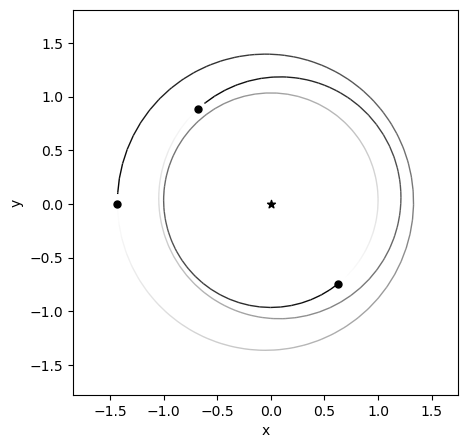

In [11]:
### 
sa = rebound.SimulationArchive(datafolder+'resonant/simulation_archives/runs/sa0000010.bin')# read the file
sim2 = sa[0] # read the initial condition
fig = rebound.OrbitPlot(sim2) #plot it first